In [1]:
#= 
first section (first 428 lines) has all the functions (external to Luna) and variables/parameters used
second section is where the 1st is propagated
third section is where the 2nd is propagated 
fourth section is where the 3rd is propagated and an RDW is hopefully emitted
fifth section is where you can set a range and analysis the 3rd stage
sixth section is where the UV mirrors HD7203 or HD7201 is simulated (need the csv in the file location to use)
seventh section is where you can grab any stage of the simulation and overlay it with an experimental spectrum saved in the file location 
eighth and ninth section produces graphs similar to Luna graphs but with more user freedom


The first stage (stg1) fiber to broaden bandwidth then compress 160 fs pulse to ~21 fs with a series of optical components including chirp mirrors
The second stage (stg2) fiber broadens bandwidth even more then compresses the pulse further down to ~9.5fs
Lastly, the third stage (stg3) is the soliton stage which is where the UV RWD emission is generated via adjusting the pressure of the gas and the input energy of the pulse (to limit ionization)
=#

In [2]:
#= Array simulation:
  Check stage 1 parameters are correct:
        gas1 = :Kr		#gas in the fiber, Kr is krypton 
        energy1 = 350e-6	#pulse energy in Joules
        pressure1 = 2.7		#gas pressure in bar
  Check stage 2 paramters, the ones listed below will give an output pulse duration of 9.5fs after compression through prop2
    gas2=  :Ar #gas in the fiber, Ar is argon
    energy2= 200e-6 #in joules
    pressure2= 0.5 #in bar
  Manually set stage 3 gas, pressure, energy parameters in fourth cell
=#

In [3]:
using Luna  #declare package to use propagation functions, need to add to Julia REPL before first use, see GitHub for documentation
import PyPlot as plt #for some plotting
using Plots #for some other plotting
gr() #backend for Plots
using DelimitedFiles #for reading in csv files, used in  propHD7203 and hd7201
using PyCall #this line and next are how to import numpy into Julia
np = pyimport("numpy")
using LinearAlgebra #for central wavelength calculation

##global variables:
    #parameters of input pulse using the Pharos laser
    λ0 = 1030e-9	    #central wavelength in meters
    τfwhm_initial= 165e-15	#pulse duration in seconds
    #parameters of the first fiber
    a1 = 268e-6		#core radius in meters
    flength1 = 1.0 	#fiber length in meters
    gas1 = :Kr		#gas in the fiber, Kr is krypton 
    energy1 = 350e-6	#pulse energy in Joules
    pressure1 = 2.7		#gas pressure in bar
    #parameters of the second fiber
    a2 = 268e-6		#core radius in meters
    flength2 = 1.8 	#fiber length in meters
    gas2=  :Ar #gas in the fiber, Ar is argon
    energy2= 200e-6 #in joules
    pressure2= 0.5 #in bar
    #parameters of the third fiber
    a3 = 100e-6		#core radius in meters
    flength3 = 1	#fiber length in meters
    #for stg1, stg2, stg3 functions to make arrays which are mutuable in and out of functions
    compressor_stg1 =  Array{Any}(undef,1) #only using the first index but need array since mutuable in/out of functions
    compressor_stg2 =  Array{Any}(undef,6) #one index for each tested output pulse duration
    compressor_stg3 =  Array{Any}(undef,5,100) #arbituary chosen size; first index corresponds to stg2[a] for LunaPulse, second is the properties incoming to 3rd stage
    box =  Array{Any}(undef,1) #for propagation of pickoff mirrors in soliton box
    #plotting/grid parameters
    FTL=false #turns off the transformed limited case
    modes= 4 		 #total number of modes
    trange1 = 1e-12 	    #time grid size in seconds for 1st stage
    λrange1=(700e-9, 1200e-9) #grid wavelength range in meters for plots for graphs
    λlims_stg1 = (700e-9, 1200e-9) #grid wavelength range in meters for fibers for propagation
    trange2 = 500e-15  	    #time grid size in seconds 
    λrange2=(700e-9, 1200e-9) #grid wavelength range in meters for graphs
    λlims_stg2 = (200e-9, 3e-6) #grid wavelength range in meters for fibers for propagation
    trange3 = 300e-15	    #time grid size in seconds
    λrange3= (100e-9, 1400e-9) #grid wavelength range in meters for graphs
    λlims_stg3 = (100e-9, 1400e-9) #grid wavelength range in meters for fibers for propagation

    a=1 #arbituary indexes to save compressor func as arrays 
    i=1


##functions:

#return central wavelength for given length in fiber for given wavelegnth range
function get_central_wavelength(i,specrange, flength, func)
    λ, Iλ=Processing.getIω(func,:λ, flength; specrange) #get arrays from output SED for wavelengths in specrange at flength
    Iλd=Iλ[:,1,1] #only 1st mode
    P=LinearAlgebra.dot(λ[:], Iλd[:]) #calculate central wavelength: (1/TotalPower)*sum(λ*SED)
    λ00[i]=P/sum(Iλd)
end

#:::'##::::'######::'########:::::'######::'########::::'###:::::'######:::'########:
#:'####:::'##... ##:... ##..:::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#:.. ##::: ##:::..::::: ##::::::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#::: ##:::. ######::::: ##:::::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#::: ##::::..... ##:::: ##::::::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
#::: ##:::'##::: ##:::: ##:::::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
#:'######:. ######::::: ##:::::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#:......:::......::::::..:::::::::......::::::..:::::..:::::..:::......::::........::

#simulates the pulse down the first fiber
function stg1(gas, energy, pressure)
    #propagate through the first stage fiber to broaden bandwidth with the parameters listed above
    compressor_stg1[1]= prop_capillary(a1, flength1, gas, pressure; λ0=λ0, τfwhm=τfwhm_initial, energy, λlims=λlims_stg1, trange=trange1, modes) 
end
        
#compress in time the first stage with chirp mirrors
#physical order in lab: 1m of fiber>window>lens>2m of air>chirp mirrors>2m of air>lens>window>next fiber
# this mutates its input as required for the LunaPulse
function prop1!(Eω, grid)
    Fields.prop_material!(Eω, grid, :SiO2, 1e-3, λ0) # 1 1-mm window
    Fields.prop_material!(Eω, grid, :BK7, 2.1e-3, λ0) # 1 bk7 lens LA1254-Bc thorlabs
    Fields.prop_material!(Eω, grid, :Air, 2, λ0) # 2m of air
    Fields.prop_mirror!(Eω, grid, :HD120, 4) #4 chirp mirror bounces
    Fields.prop_material!(Eω, grid, :Air, 2, λ0) # 2m of air path total
    Fields.prop_material!(Eω, grid, :BK7, 2.1e-3, λ0) # 1 bk7 lenses LA1254-Bc thorlabs
    Fields.prop_material!(Eω, grid, :SiO2, 1e-3, λ0) # 1 1-mm window

end
    
# non-mutating version of prop! as required for plotting
function prop1(grid, Eω)
    Eωout = copy(Eω)
    prop1!(Eωout, grid)
    Eωout
end


#:'#######::'##::: ##:'########::::::'######::'########::::'###:::::'######:::'########:
#'##.... ##: ###:: ##: ##.... ##::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#..::::: ##: ####: ##: ##:::: ##:::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#:'#######:: ## ## ##: ##:::: ##::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#'##:::::::: ##. ####: ##:::: ##:::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
# ##:::::::: ##:. ###: ##:::: ##::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
# #########: ##::. ##: ########:::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#.........::..::::..::........:::::::......::::::..:::::..:::::..:::......::::........::

#simulates the pulse down the second fiber
function stg2(a, gas, energy, pressure) 
    #obtain pulse from the first fiber end via LunaPulse
     pulse_in_stg2 = Pulses.LunaPulse(compressor_stg1[1]; energy, propagator=prop1!) #input pulse from the 1st stage
    #propagate through the second stage fiber to broaden bandwidth even more, with parameters listed above
    compressor_stg2[a]= prop_capillary(a2, flength2, gas, pressure; pulses=[pulse_in_stg2], λ0=λ0, trange=trange2, λlims=λlims_stg2, modes=modes)
end

#compress in time the second stage with chirp mirrors and other optical components
#=physical order in lab: First fiber>optical components>second fiber> 1mm fused silica window >4-5 m of air path length >1mm MgF2 window> 4 (2 pairs) of PC147 chirped mirrors from ultrafast innovations 6 (3 pairs) of PC147 chirped mirrors from ultrafast innovations  > 3.5mm fused silica polarizer > wedges >third fiber     =#
#this mutates its input as required for the LunaPulse
function prop2!(Eω, grid)
    Fields.prop_material!(Eω, grid, :SiO2, 1e-3, λ0) # 1 1-mm fused silica window 
    Fields.prop_material!(Eω, grid, :Air, 3.9, λ0) # 4m of air total
    Fields.prop_material!(Eω, grid, :MgF2, 1e-3, λ0) #1mm Magnesium Fluoride window
    Fields.prop_mirror!(Eω, grid, :PC147, 4) #4 chirped mirror bounces (not pairs but need to be in multiples of 2 due to the material induced out of phase oscillations of GDD)
    Fields.prop_material!(Eω, grid, :SiO2, 3.5e-3, λ0) # 1 3.5 mm fused silica polarizer
  _, Eωopt = Fields.optcomp_material(Eω, grid, :MgF2, λ0, -1e-2, 1e-2) #wedges for optimizing compression, last numbers are  min_thickness then max_thickness
  Eω .= Eωopt
end

# non-mutating version of prop! as required for plotting
function prop2(grid, Eω)
    Eωout = copy(Eω)
    prop2!(Eωout, grid)
    Eωout
end

function prop3!(Eω, grid)
    Fields.prop_material!(Eω, grid, :SiO2, 1e-3, λ0) # 1 1-mm fused silica window 
    Fields.prop_material!(Eω, grid, :Air, 1, λ0) # 1m of air total
    Fields.prop_material!(Eω, grid, :MgF2, 1e-3, λ0) #1mm Magnesium Fluoride window
end

# non-mutating version of prop! as required for plotting
function prop3(grid, Eω)
    Eωout = copy(Eω)
    prop3!(Eωout, grid)
    Eωout
end

#:'#######::'########::'########::::::'######::'########::::'###:::::'######:::'########:
#'##.... ##: ##.... ##: ##.... ##::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#..::::: ##: ##:::: ##: ##:::: ##:::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#:'#######:: ########:: ##:::: ##::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#:...... ##: ##.. ##::: ##:::: ##:::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
#'##:::: ##: ##::. ##:: ##:::: ##::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
#. #######:: ##:::. ##: ########:::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#:.......:::..:::::..::........:::::::......::::::..:::::..:::::..:::......::::........::

#simulates the pulse down the third fiber
function stg3(a, i, gas3, energy3, pressure3, infunc) 
    #obtain pulse from the first fiber end via LunaPulse
    pulse_in_stg3 = Pulses.LunaPulse(infunc; energy=energy3, propagator=prop2!) #input pulse from the 2nd stage
    #propagate through the second stage fiber to broaden bandwidth even more, with parameters listed above
    compressor_stg3[a,i]= prop_capillary(a3, flength3, gas3, pressure3; pulses=[pulse_in_stg3], λ0=λ0, trange=trange3, λlims=λlims_stg3, modes=modes)
end


#'####:'##::: ##::::'########:::'#######::'##::::'##:
#. ##:: ###:: ##:::: ##.... ##:'##.... ##:. ##::'##::
#: ##:: ####: ##:::: ##:::: ##: ##:::: ##::. ##'##:::
#: ##:: ## ## ##:::: ########:: ##:::: ##:::. ###::::
#: ##:: ##. ####:::: ##.... ##: ##:::: ##::: ## ##:::
#: ##:: ##:. ###:::: ##:::: ##: ##:::: ##:: ##:. ##::
#'####: ##::. ##:::: ########::. #######:: ##:::. ##:
#....::..::::..:::::........::::.......:::..:::::..::

#calculates angular frequency 
function wlfreq(ωλ) 
    c=3e8 #speed of light in vacuum 
    2π*c/ωλ
end

#pickoff mirror for 450 to 550nm from UFI, need to have the data file stored on computer where the varaible dat speficies with format: col1 - wavelength, col2 - GDD correspondong to col1, col3- wavelength, col4- reflecivity corresponding to col3
function propHD7201!(Eω, grid) #mutuable function for LunaPulse
    dat = readdlm(joinpath(Utils.datadir(), "\\Users\\kinca\\Documents\\ucf\\research\\lcls\\code\\61923\\mirrors\\HD7201.csv"), ','; skipstart=1)  #read data from file
    λR = dat[:, 1] * 1e-9 #assign 1st colou
    R = dat[:, 2] # reflectivity per mirror 
    λGDD = dat[:, 3] * 1e-9
    ω =  wlfreq.(λGDD)
    GDD = dat[:, 4] .* 1e-30 # GDD per mirror
    reflections=1
    λ0=1030e-9
    λmin=450e-9
    λmax=550e-9
    Fields.prop_mirror!(Eω, grid, reflections, λR, R, λGDD, GDD, λ0, λmin, λmax)
end
function propHD7201(grid, Eω) #nonmutuable function for graphs
    Eωout = copy(Eω)
    propHD7201!(Eωout, grid)
    Eωout
end

#pickoff mirror for  350 to 460nm from UFI, need to have the data file stored on computer where the varaible dat speficies with format: col1 - wavelength, col2 - GDD correspondong to col1, col3- wavelength, col4- reflecivity corresponding to col3
function propHD7203!(Eω, grid) #mutuable function for LunaPulse
    dat = readdlm(joinpath(Utils.datadir(), "\\Users\\kinca\\Documents\\ucf\\research\\lcls\\code\\61923\\mirrors\\HD7203.csv"), ','; skipstart=1)  #read data from file
    λR = dat[:, 1] * 1e-9 #assign 1st colou
    R = dat[:, 2] # reflectivity per mirror 
    λGDD = dat[:, 3] * 1e-9
    ω =  wlfreq.(λGDD)
    GDD = dat[:, 4] .* 1e-30 # GDD per mirror
    reflections=1
    λ0=1030e-9
    λmin=350e-9
    λmax=460e-9
    Fields.prop_mirror!(Eω, grid, reflections, λR, R, λGDD, GDD, λ0, λmin, λmax)
end
function propHD7203(grid, Eω) #nonmutuable function for graphs
    Eωout = copy(Eω)
    propHD7203!(Eωout, grid)
    Eωout
end

#simulates pulse within soliton box (mainly used for pickoff mirrors)
function soliton_box(i,gas4, energy4, pressure4, infunc, propp) 
    #obtain pulse from the first fiber end via LunaPulse
    pulse_in_last = Pulses.LunaPulse(infunc; energy=energy4, propagator=propp) #input pulse from the 3rd stage
    #propagate through the second stage fiber to broaden bandwidth even more, with parameters listed above
    box[i]= prop_capillary(a3, flength4, gas4, pressure4; pulses=[pulse_in_last], λ0=λ0, trange=trange3, λlims=λlims_stg3, modes=modes)
end

#:'######:::'########:::::'###::::'########::'##::::'##::'######::
#'##... ##:: ##.... ##:::'## ##::: ##.... ##: ##:::: ##:'##... ##:
# ##:::..::: ##:::: ##::'##:. ##:: ##:::: ##: ##:::: ##: ##:::..::
# ##::'####: ########::'##:::. ##: ########:: #########:. ######::
# ##::: ##:: ##.. ##::: #########: ##.....::: ##.... ##::..... ##:
# ##::: ##:: ##::. ##:: ##.... ##: ##:::::::: ##:::: ##:'##::: ##:
#. ######::: ##:::. ##: ##:::: ##: ##:::::::: ##:::: ##:. ######::
#:......::::..:::::..::..:::::..::..:::::::::..:::::..:::......::

#graphs before compression 
function graphs_b4(func, range, bandpasss) 
    Plotting.time_1D(func; modes=1,  FTL=FTL, trange=(-300e-15, 300e-15), bandpass=bandpasss) 		
        #^^plot of power as function of time for the mode specified 
         #can add bandpass= to look at pulse duration for certain wavelegnths
    Plotting.spec_1D(func; log10=false, modes=1,  λrange=range)
        #^^ plots SED as function of wavelength for each mode
    Plotting.stats(func)
        #^^ plots lots of info about each mode
    Plotting.energy(func; modes=1, bandpass=bandpasss)
        #^^ graphs the energy as a function of distance for given wavelength range
end

#graphs after compression 
function graphs_after(func, propp, range, bandpasss) #where propp corresponds to prop1, or prop2 for compression
    Plotting.time_1D(func; modes=1, trange=(-300e-15, 300e-15), FTL=FTL, propagate=propp, bandpass=bandpasss) 		
        #^^plot of power as function of time for the mode specified 
        #can add bandpass= to look at pulse duration for certain wavelegnths
    Plotting.spec_1D(func; log10=false, modes=1, λrange=range)
        #^^ plots SED as function of wavelength for each mode
    Plotting.stats(func)
        #^^ plots lots of info about each mode
    Plotting.energy(func; modes=1, bandpass=bandpasss)
    #^^ graphs the energy as a function of distance for given wavelength range
end

#graphs the normalized SED vs wavelength, based on for loop from stg3
#some arrays may need the wavelegnth to be cut off later/sooner than the 1300
function graphs2_normSED_λ(func, j, a, pt1)

    if (a==1) #if statements to label legend on graphs
        ls=:dot
        time="5.29fs"
    elseif (a==2)
        ls=:solid
        time="7.37fs"
    elseif (a==3)
        ls=:dash
        time="9.21fs"
    elseif (a==4)
        ls=:dashdot
        time="10.74fs"
    else
        ls=:solid
    end
 
    #general plotting parameters
    xlims= (100, 500)
    xlabel="Wavelength (nm)"
    ylims= (0,1)
    ylabel= "Normalized Spectral energy density"
    title="Normalized SED vs λ with varying gas and pressure"
    y=0 #fills under the curve in solid color
    #plotting arrays/variables
    λ= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    λ[j], Iλ[j]=Processing.getIω(compressor_stg3[a, j], :λ,1) #get values of from the compressor function
    λ[j]=first(λ[j],1300) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 1300) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plot!(pt1, λ[j]*1e9, Iλ_norm[j], fillrange=y, title=title, xlims=xlims, xlabel=xlabel, ylabel=ylabel, ylims=ylims, label="$(pressure3[a,j]) bar $(gas3[a,j]) $(time)", color="$(color[j])", linestyle=ls)
end


#graphs the normalized SED vs angular frequnecy, based on for loop from stg3
function graphs2_normSED_ω(func, j)
    
    #general plotting parameters
    plt.xlim(10e14, 30e14)
    plt.xlabel("Angular Frequency (rad/s)")
    plt.ylabel("Normalized Spectral energy density")
    plt.ylim(0,1)
    plt.title("Normalized SED vs Angular Frequency with varying gas and pressure")

    #plotting arrays/variables
    w= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    w[j], Iλ[j]=Processing.getIω(compressor_stg3[a, j], :ω,1) #get values of from the compressor function
    w[j]=first(w[j],1300) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 1300) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot(w[j], Iλ_norm[j], label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
end

#graphs the normalized SED vs frequnecy, based on for loop from stg3
function graphs2_normSED_f(func, j)
    #general plotting parameters
    plt.xlim(100, 500)
    plt.xlabel("Frequency (THz)")
    plt.ylabel("Normalized Spectral energy density")
    plt.ylim(0,1)
    plt.title("Normalized SED vs Frequency with varying gas and pressure")

    #plotting arrays/variables
    f= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    f[j], Iλ[j]=Processing.getIω(func, :f,1) #get values of from the compressor function
    f[j]=first(f[j],1300) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 1300) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot(f[j]*1e-12, Iλ_norm[j], label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
end

#graphs the normalized SED vs frequnecy, based on for loop from stg3
function graphs2_normSED_e(func,a, j)
        #general plotting parameters
    plt.xlim(0, 9)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Normalized Spectral energy density")
    plt.ylim(0,1)
    plt.title("Normalized SED vs Energy with varying gas and pressure")

    #plotting arrays/variables
    f= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    f[j], Iλ[j]=Processing.getIω(func, :f,1) #get values of from the compressor function
    print(size(f[j]))
    f[j]=first(f[j],1300) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 1300) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot(f[j]*4.14e-15, Iλ_norm[j], label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
    print(size(f[j]))

end

#graphs the normalized SED vs frequnecy, based on for loop from stg3
function graphs2_normSED_ezoom(func,a, j)
        #general plotting parameters
    plt.xlim(6, 9)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Normalized Spectral energy density")
    plt.ylim(0,1)
    plt.title("Normalized SED vs Energy with varying gas and pressure")

    #plotting arrays/variables
    f= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    f[j], Iλ[j]=Processing.getIω(func, :f,1) #get values of from the compressor function
   # print(size(f[j]))
    f[j]=last(f[j],1000) #filter out data points greater than window to normalize properly
    Iλ[j]=last(Iλ[j], 1000) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot(f[j]*4.14e-15, Iλ_norm[j], label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")

end

graphs2_normSED_ezoom (generic function with 1 method)

[ Info: X+Y polarisation not required.
[ Info: Freq limits 0.25 - 0.43 PHz
[ Info: Samples needed: 2569.65, samples: 4096, δt = 389.16 as
[ Info: Requested time window: 1000.0 fs, actual time window: 1594.0 fs
[ Info: Grid: samples 2048 / 4096, ωmax 4.04e+15 / 8.07e+15
[ Info: Using PPT ionisation rate.
[ Info: Found cached PPT rate for 13.992094691484 eV, 1030.0 nm
[ Info: Using radial modal integral.
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Starting propagation
[ Info: Progress: 41.02 %, ETA: 00:00:07, stepsize 4.40e-03, err 0.32, repeated 0
[ Info: Propagation finished in 8.107 seconds, 190 steps
sys:1: UserWarning: The figure layout has changed to tight


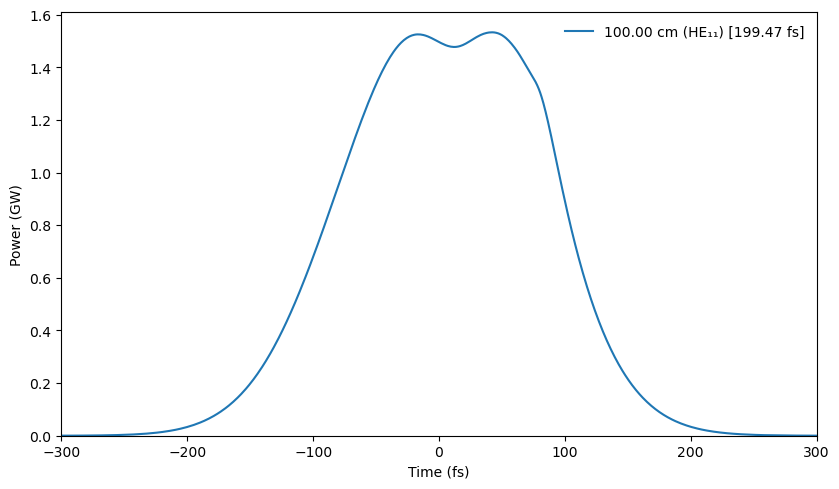

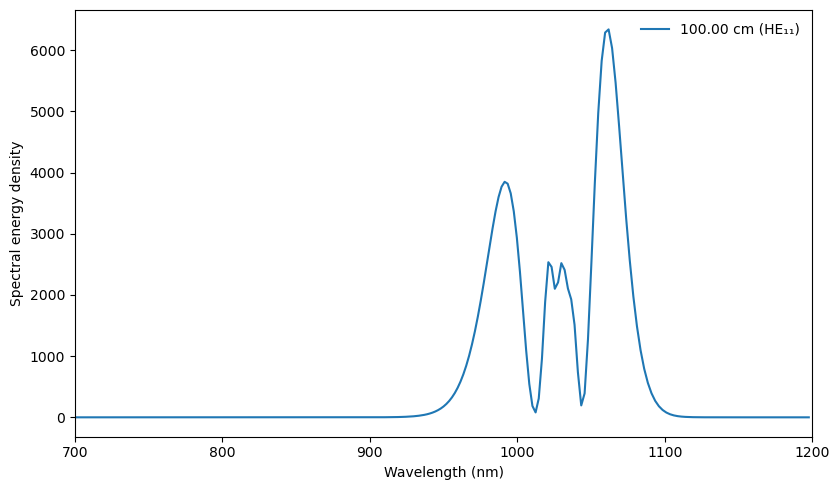

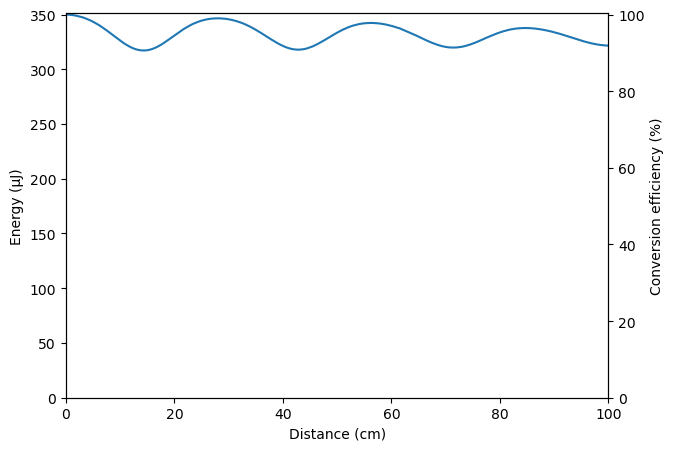

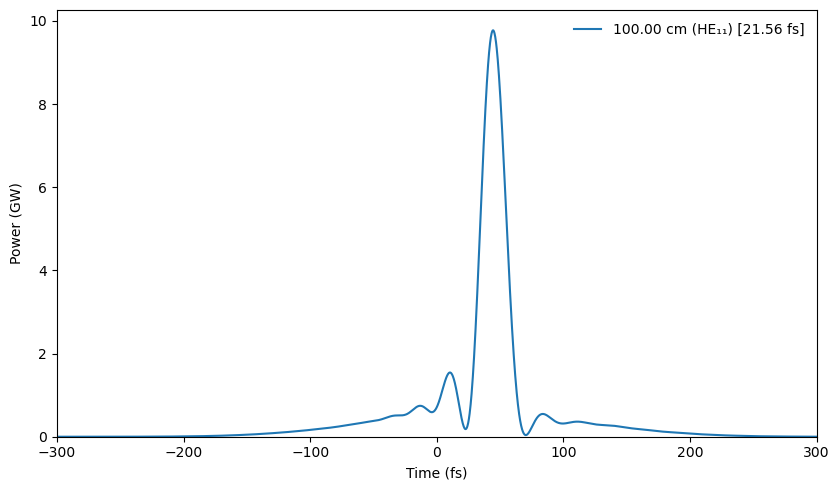

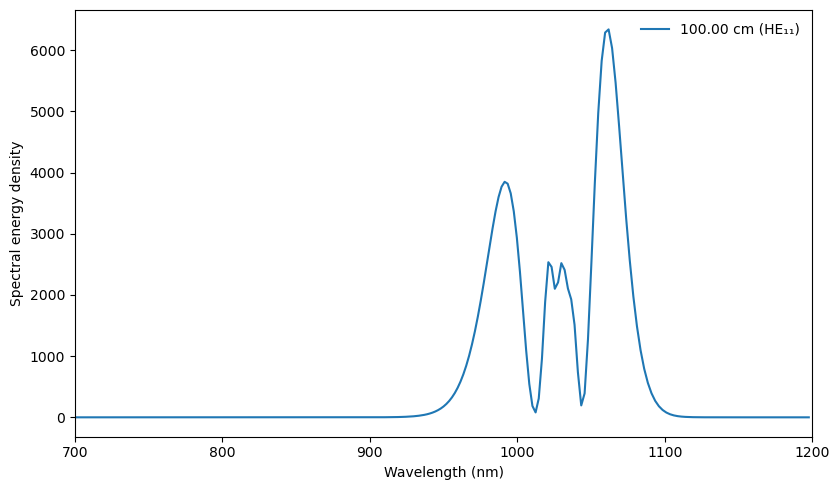

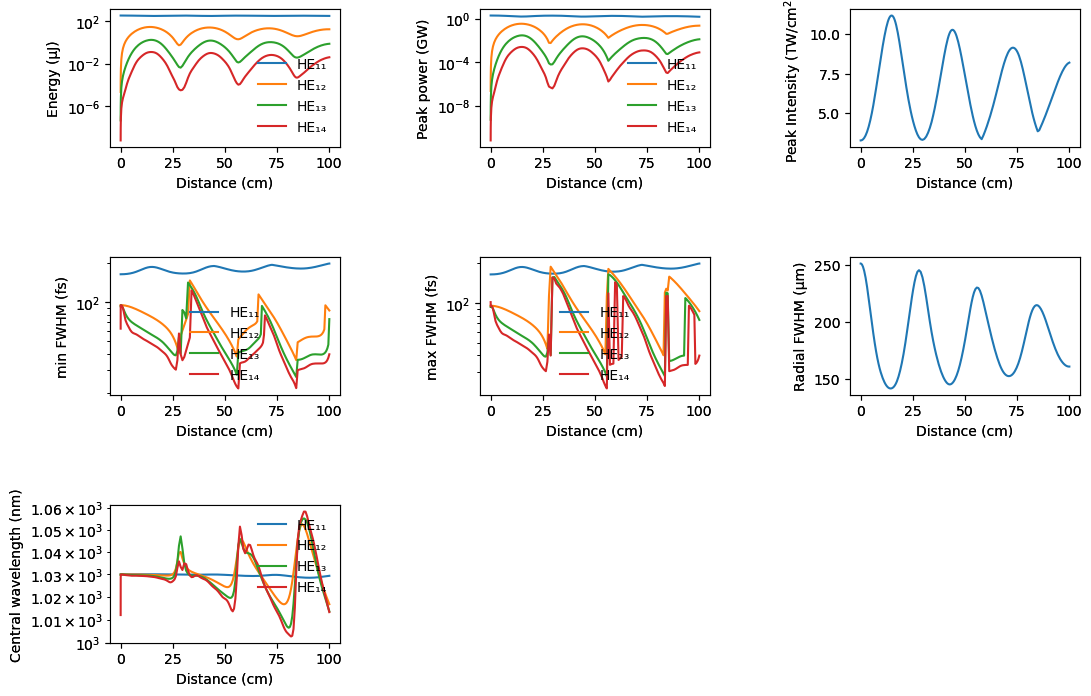

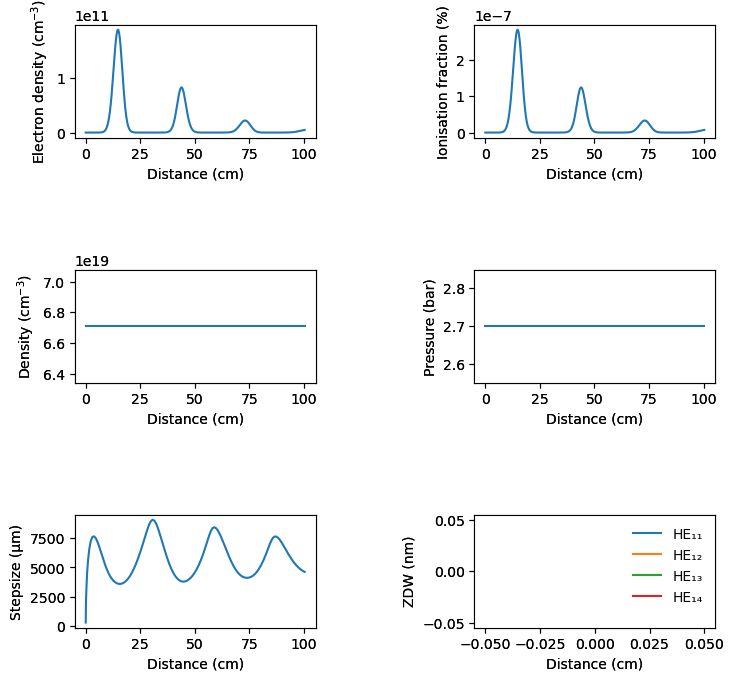

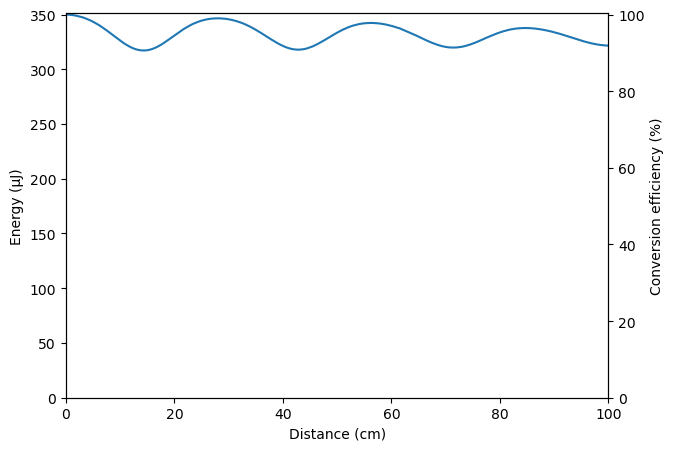

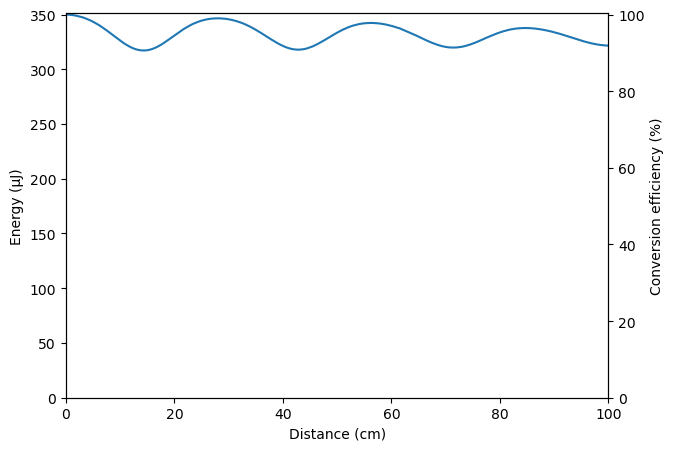

In [4]:
#:::'##::::'######::'########:::::'######::'########::::'###:::::'######:::'########:
#:'####:::'##... ##:... ##..:::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#:.. ##::: ##:::..::::: ##::::::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#::: ##:::. ######::::: ##:::::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#::: ##::::..... ##:::: ##::::::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
#::: ##:::'##::: ##:::: ##:::::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
#:'######:. ######::::: ##:::::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#:......:::......::::::..:::::::::......::::::..:::::..:::::..:::......::::........::
bandpass=λrange1 #bandwidth range for time domain graphs

stg1(gas1, energy1, pressure1) #use predefined function to simulate pulse down first fiber
graphs_b4(compressor_stg1[1], λrange1, bandpass) #plot pulse after first fiber before compression- function, predefined λrange in global variables  
graphs_after(compressor_stg1[1], prop1, λrange1, bandpass) #plot pulse after compression - prop1 for first fiber, predefined λrange in global variables 

[ Info: X+Y polarisation not required.
[ Info: Freq limits 0.10 - 1.50 PHz
[ Info: Samples needed: 4496.89, samples: 8192, δt = 111.19 as
[ Info: Requested time window: 500.0 fs, actual time window: 910.9 fs
[ Info: Grid: samples 4096 / 8192, ωmax 1.41e+16 / 2.83e+16
[ Info: Using PPT ionisation rate.
[ Info: Found cached PPT rate for 15.760834782784002 eV, 1030.0 nm
[ Info: Using radial modal integral.
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Starting propagation
[ Info: Progress: 8.41 %, ETA: 00:00:54, stepsize 2.98e-03, err 0.28, repeated 0
[ Info: Progress: 17.10 %, ETA: 00:00:48, stepsize 2.81e-03, err 0.19, repeated 0
[ Info: Progress: 27.82 %, ETA: 00:00:39, stepsize 2.26e-03, err 0.20, repeated 0
[ Info: Progress: 38.05 %, ETA: 00:00:32, s

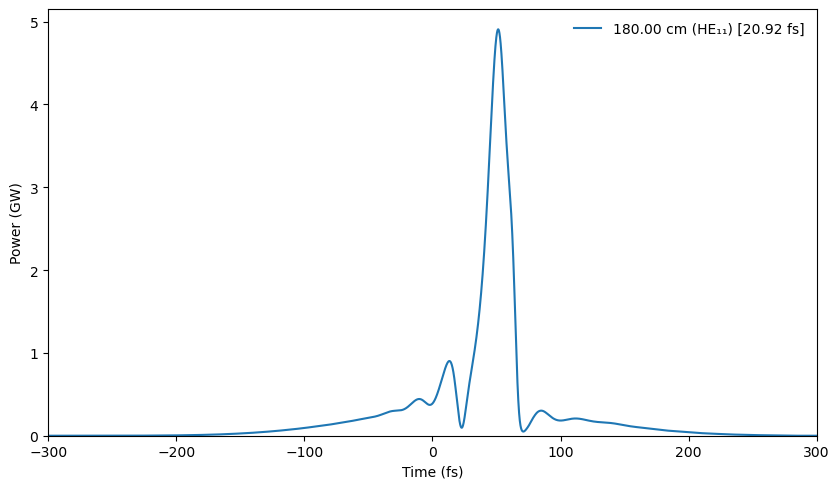

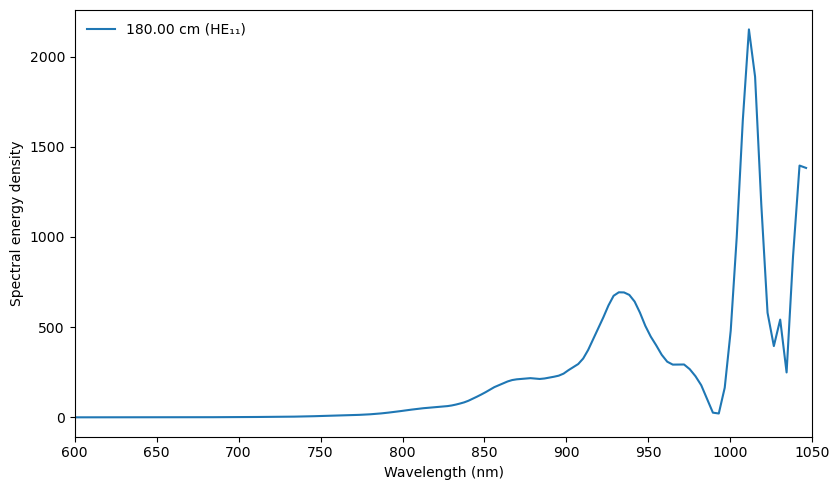

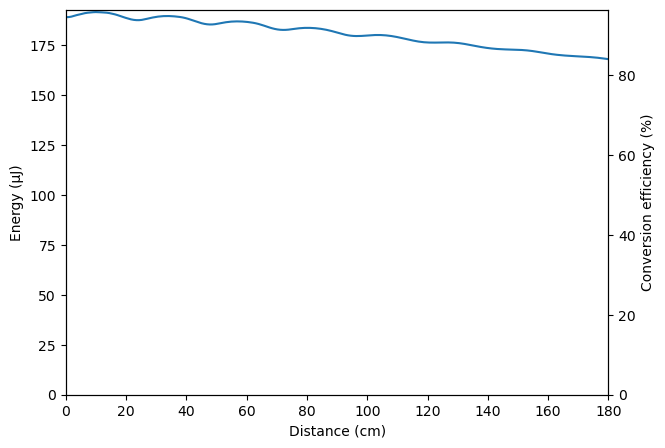

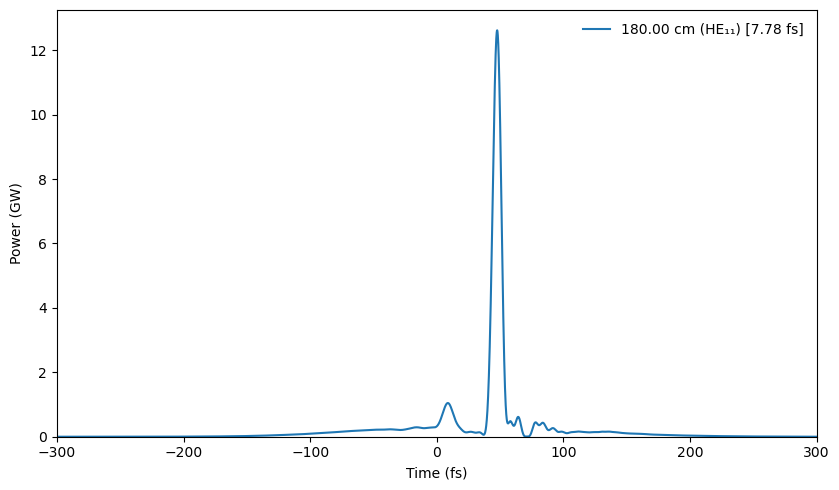

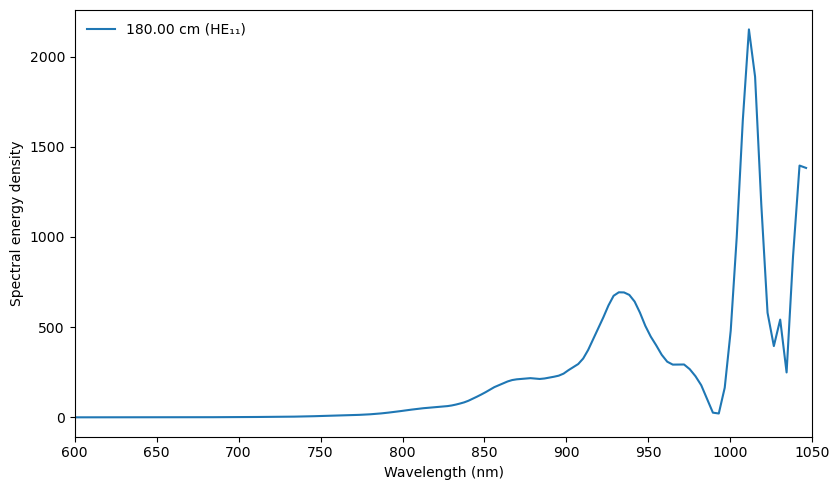

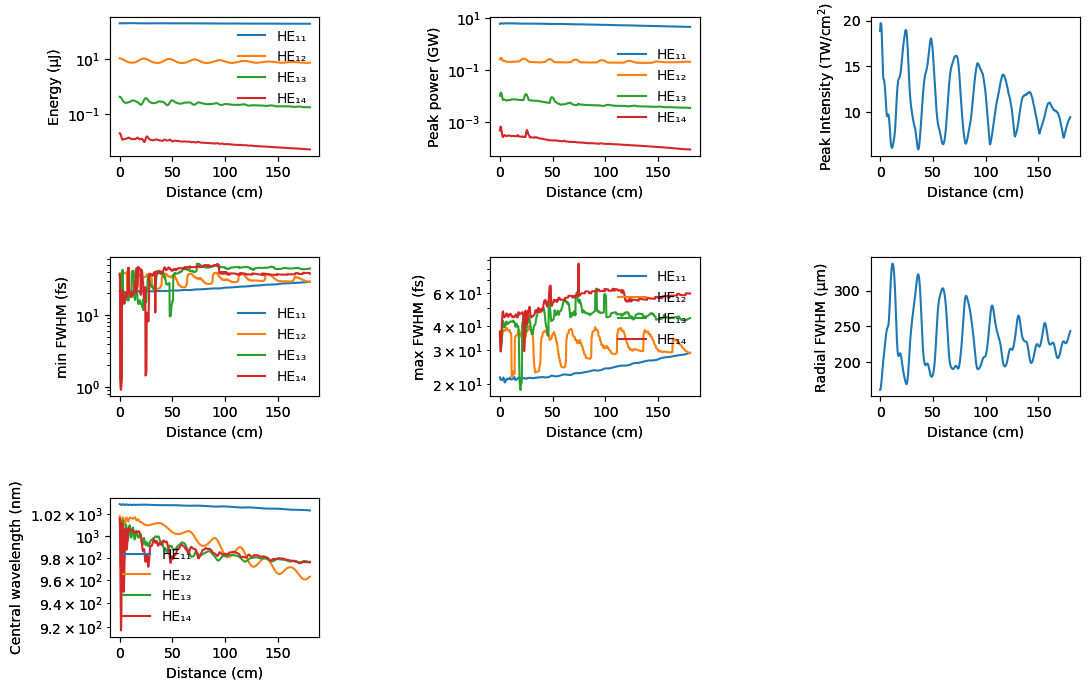

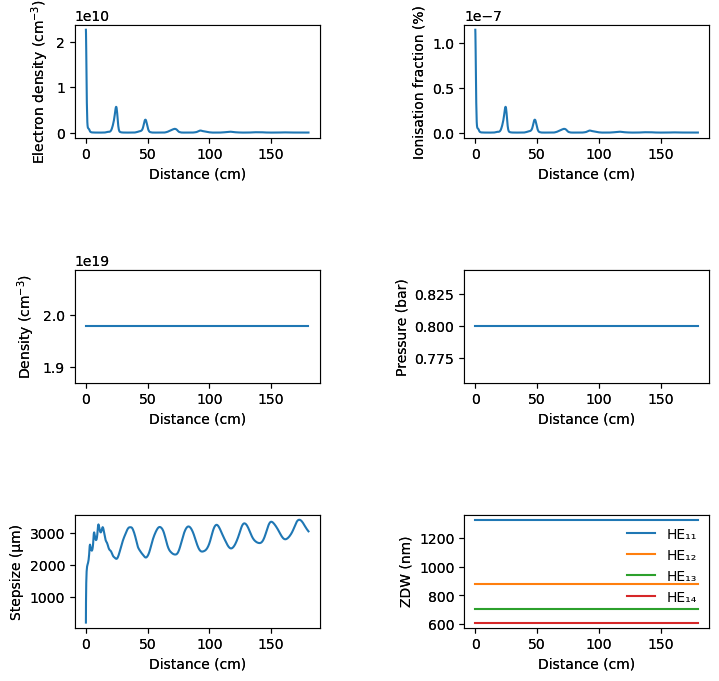

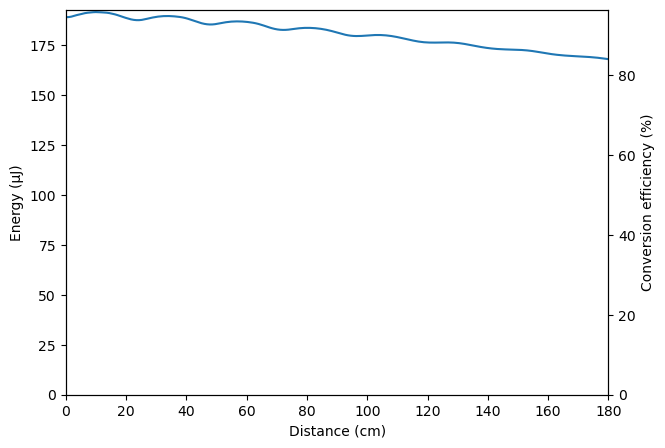

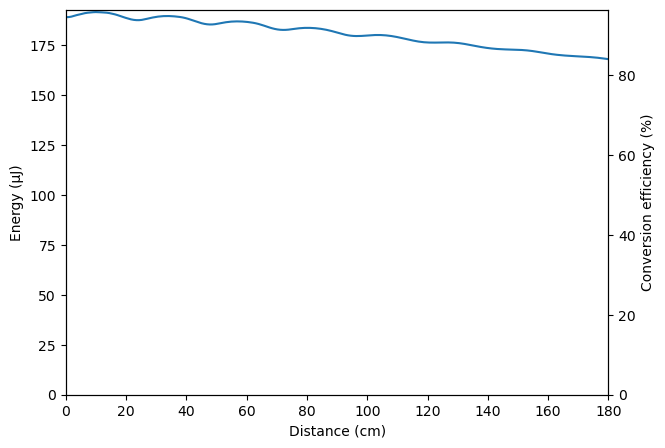

In [5]:
#:'#######::'##::: ##:'########::::::'######::'########::::'###:::::'######:::'########:
#'##.... ##: ###:: ##: ##.... ##::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#..::::: ##: ####: ##: ##:::: ##:::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#:'#######:: ## ## ##: ##:::: ##::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#'##:::::::: ##. ####: ##:::: ##:::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
# ##:::::::: ##:. ###: ##:::: ##::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
# #########: ##::. ##: ########:::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#.........::..::::..::........:::::::......::::::..:::::..:::::..:::......::::........::
λrange2 = (600e-9, 1050e-9) #for frequency domain graphs
bandpass2=λrange2 #for time graphs

stg2(a, gas2, energy2, pressure2) #simulate second fiber
graphs_b4(compressor_stg2[a], λrange2, bandpass2) #plot pulse after second fiber before compression
graphs_after(compressor_stg2[a], prop2, λrange2, bandpass2) #plot pulse after compression


[ Info: X+Y polarisation not required.
[ Info: Freq limits 0.21 - 3.00 PHz
[ Info: Samples needed: 5396.26, samples: 8192, δt = 55.59 as
[ Info: Requested time window: 300.0 fs, actual time window: 455.4 fs
[ Info: Grid: samples 4096 / 8192, ωmax 2.83e+16 / 5.65e+16
[ Info: Using PPT ionisation rate.
[ Info: Found cached PPT rate for 15.760834782784002 eV, 1030.0 nm
[ Info: Using radial modal integral.
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Starting propagation
[ Info: Progress: 5.90 %, ETA: 00:01:20, stepsize 1.16e-03, err 0.29, repeated 0
[ Info: Progress: 12.21 %, ETA: 00:01:12, stepsize 1.07e-03, err 0.17, repeated 0
[ Info: Progress: 18.76 %, ETA: 00:01:05, stepsize 1.10e-03, err 0.21, repeated 0
[ Info: Progress: 24.35 %, ETA: 00:01:02, st

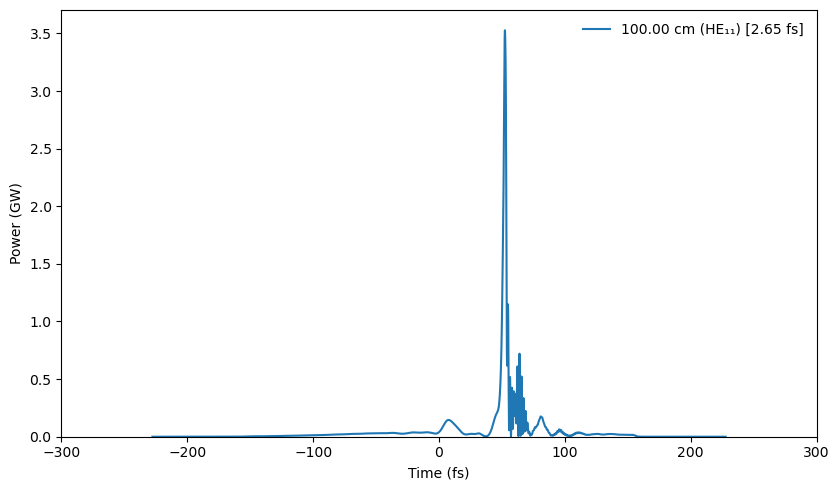

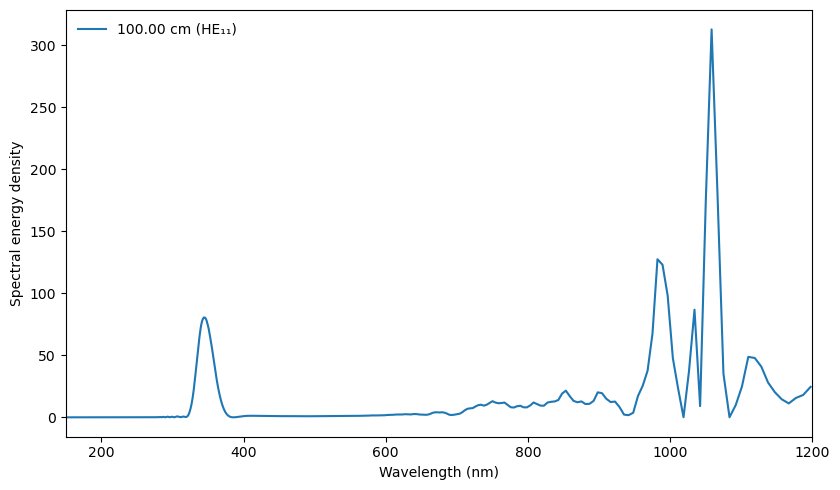

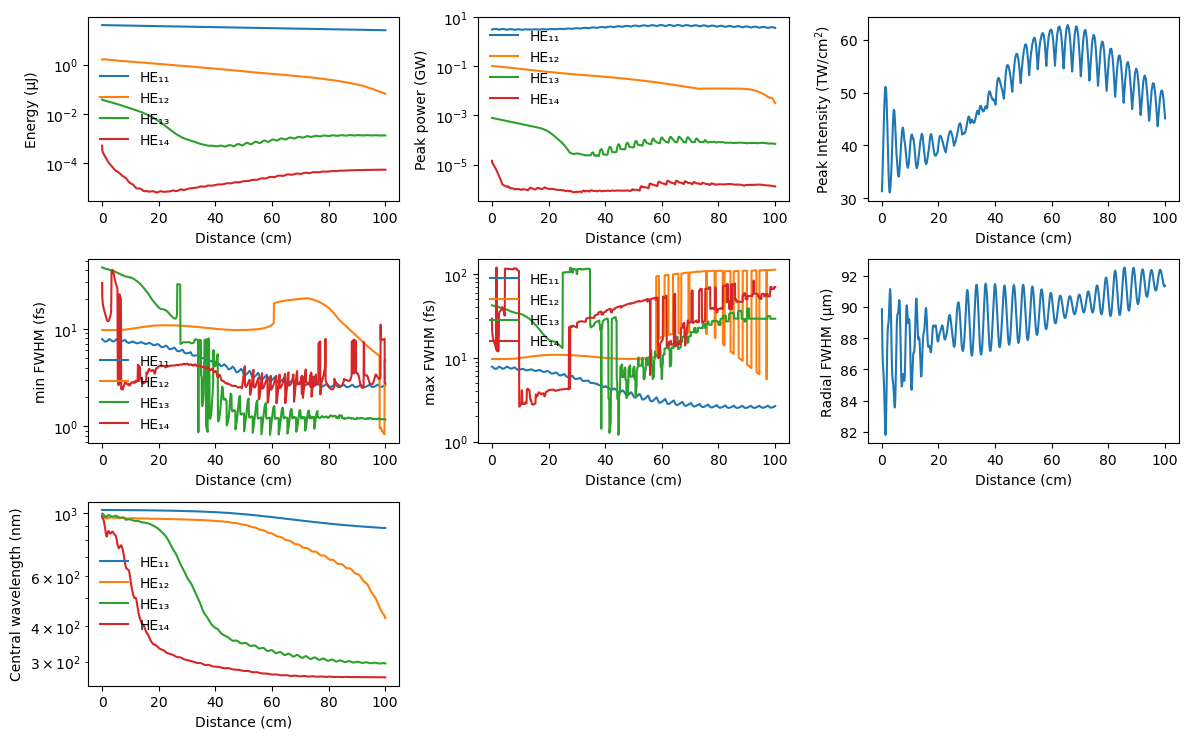

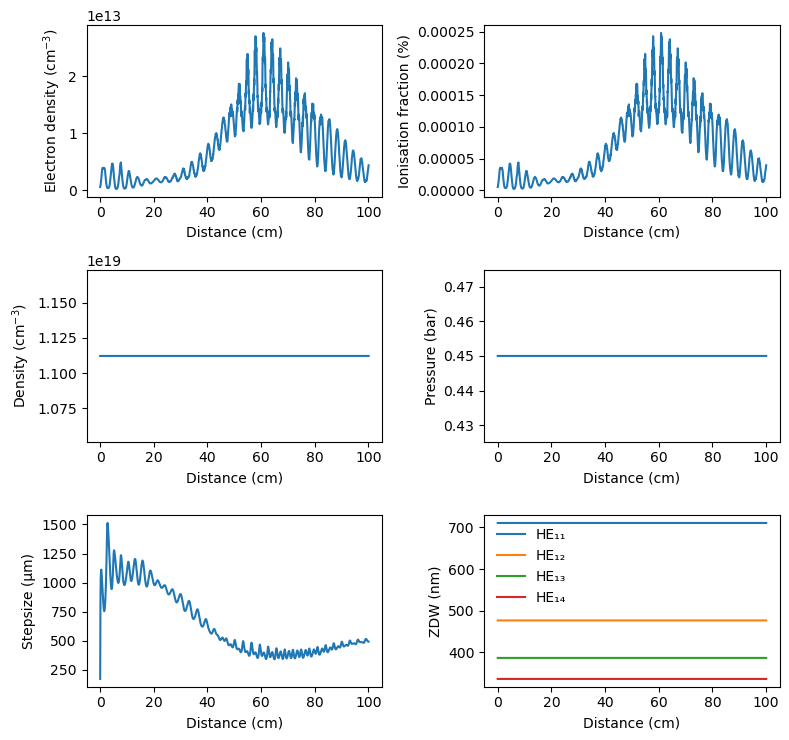

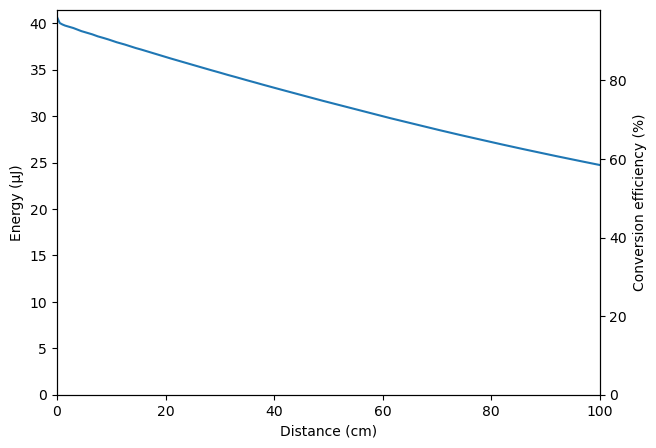

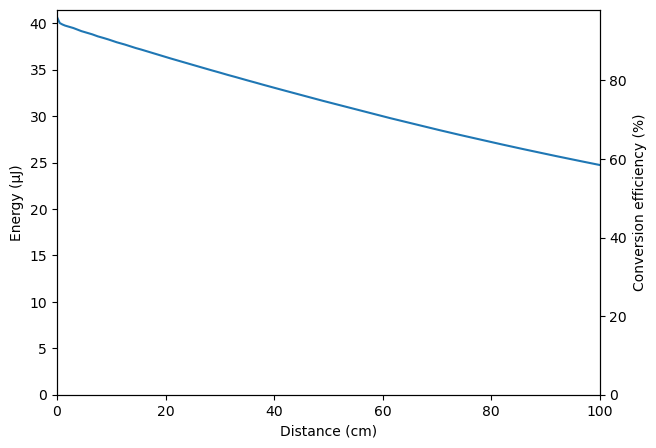

In [6]:

# #:'#######::'########::'########::::::'######::'########::::'###:::::'######:::'########:
# #'##.... ##: ##.... ##: ##.... ##::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
# #..::::: ##: ##:::: ##: ##:::: ##:::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
# #:'#######:: ########:: ##:::: ##::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
# #:...... ##: ##.. ##::: ##:::: ##:::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
# #'##:::: ##: ##::. ##:: ##:::: ##::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
# #. #######:: ##:::. ##: ########:::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
# #:.......:::..:::::..::........:::::::......::::::..:::::..:::::..:::......::::........::
bandpass3= (150e-9, 1200e-9)#for the time duration plots in graphs_b4 and graphs_after, control what wavelengths are being measured; if not assigned then measures for whole spectra
λrange3= bandpass3 #for frequency domain graphs

#3rd stage parameters
gas3= :Ar #type of gas; He is Helium, Ne is Neon, Ar is Argon, Kr is Krypton
pressure3= 0.45 #in bar
power= 23.6e-3 #in watts
power_eff= power*0.8 #effective power after loss from windows/optics/travel
rep_rate=500 #in Hz
#energy3= (power_eff/rep_rate) #calculate energy in joules
energy3=43.2e-6 #override energy calculation from power, in joules

stg3(a, i, gas3, energy3, pressure3, compressor_stg2[a]) #simulate third fiber
graphs_b4(compressor_stg3[a, i], λrange3, bandpass3) #plot pulse with full spectra

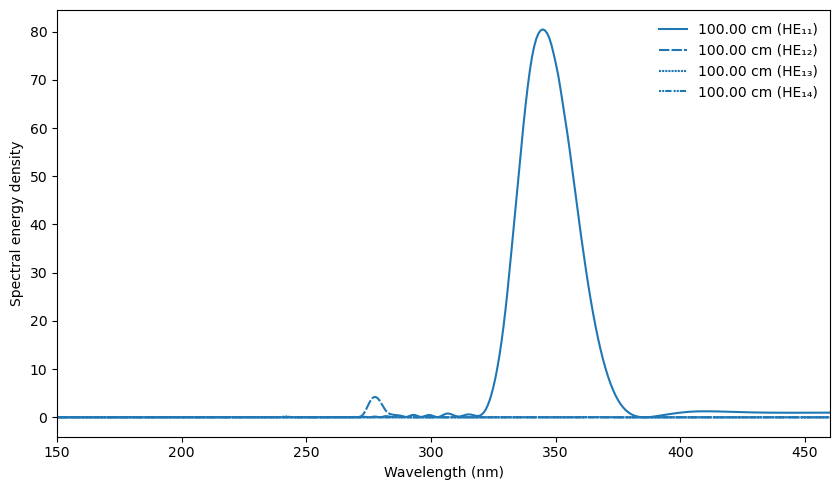

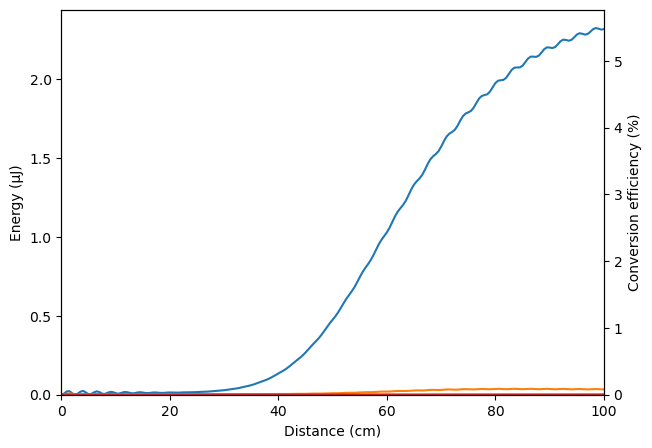

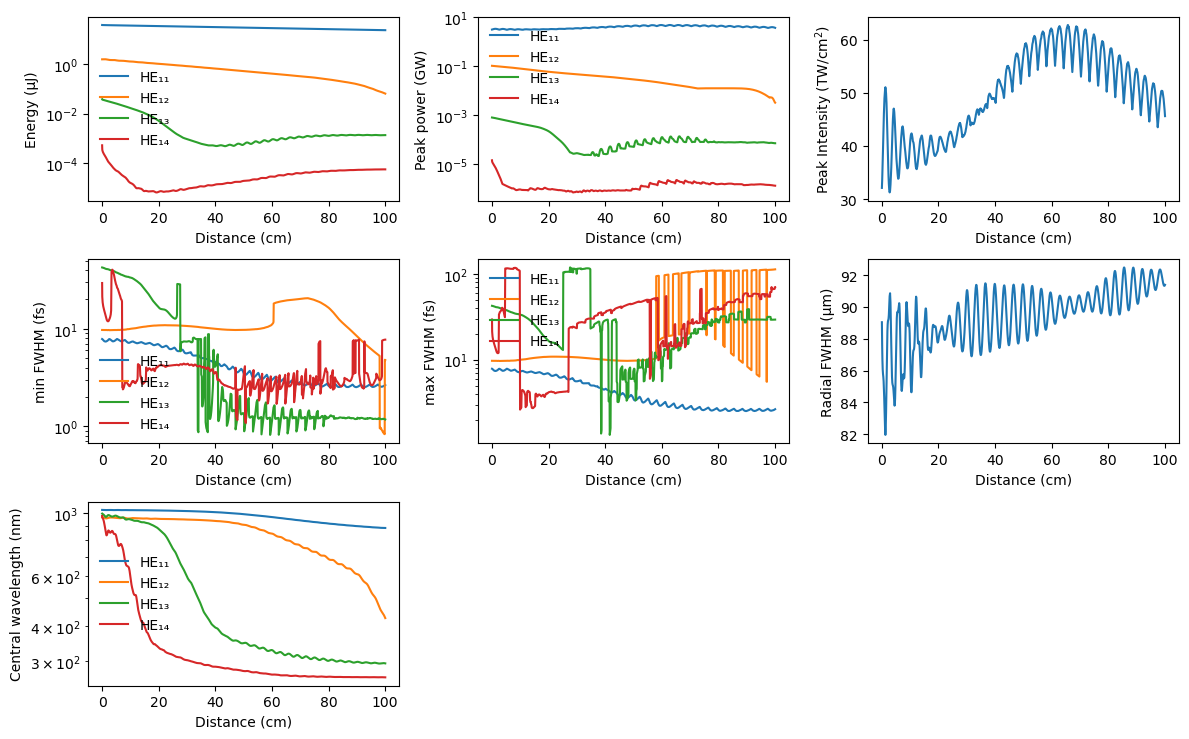

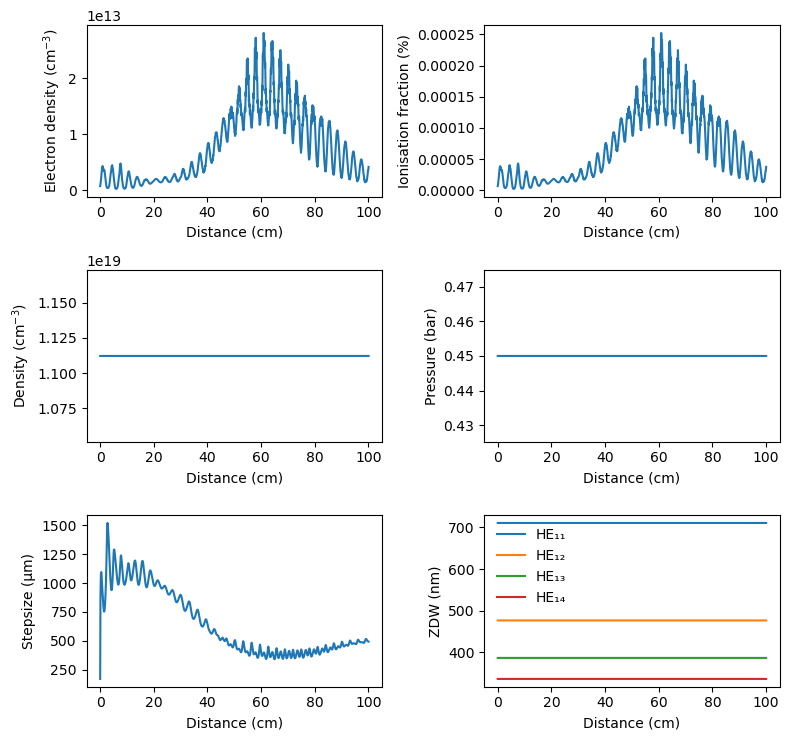

2-element Vector{PyPlot.Figure}:
 PyPlot.Figure(PyObject <Figure size 1200x750 with 7 Axes>)
 PyPlot.Figure(PyObject <Figure size 800x750 with 6 Axes>)

In [7]:
#zoom in to specific areas from 3rd stage simulation and analysis through graphs

bandpass3= (150e-9, 460e-9)#for the time duration plots in graphs_b4 and graphs_after, control what wavelengths are being measured; if not assigned then measures for whole spectra
λrange3= bandpass3 #for frequency domain graphs
Plotting.spec_1D(compressor_stg3[a, i]; log10=false,  λrange=bandpass3) #graphs wavelength vs SED with wavlength limited by λrange
Plotting.energy(compressor_stg3[a, i], bandpass=bandpass3) #graphs energy and energy efficiency in area limited by bandpass
Plotting.stats(compressor_stg3[a, i]) #graphs lots of info for each mode, such as energy/peak_power/peak_intensity/FWHM/λzd/ionisation_fraction/electron_density vs distance, , 

In [8]:
#use pickoff mirrors HD7203 or HD7201 in soliton box after 3rd stage to isolate RDW

#using the pickoff mirror hd7203
energy4=energy3*.6 # calculate energy out of third fiber for whole spectrum (60% loss is average)
gas4=:He #arbituary fiber gas, pressure, length for LunaPulse
pressure4=0.000000000001
flength4=.1

soliton_box(i,gas4, energy4, pressure4, compressor_stg3[a,i], propHD7201!) #simulate pulse through pickoff mirror speficied by last parameter
Plotting.time_1D(box[i]; modes=1, trange=(-300e-15, 300e-15), FTL=false, propagate=nothing, bandpass=bandpass3) #graph time domain of range bandpass3 after pickoff mirror
Plotting.spec_1D(box[i]; log10=false, modes=1, λrange=range) #graphs frequency domain in rnage of bandpass3 after pickoff mirror
Plotting.energy(box[i]; modes=1, bandpass=bandpass3) #graphs energy in range of bandpass3 after pickoff mirror

[ Info: X+Y polarisation not required.
[ Info: Freq limits 0.21 - 3.00 PHz
[ Info: Samples needed: 5396.26, samples: 8192, δt = 55.59 as
[ Info: Requested time window: 300.0 fs, actual time window: 455.4 fs
[ Info: Grid: samples 4096 / 8192, ωmax 2.83e+16 / 5.65e+16
[ Info: Using PPT ionisation rate.
[ Info: Found cached PPT rate for 24.588208407672 eV, 1030.0 nm
[ Info: Using radial modal integral.
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Starting propagation
[ Info: Propagation finished in 1.054 seconds, 5 steps


LoadError: MethodError: no method matching iterate(::typeof(range))

[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
[0m[90m   @[39m [90mBase[39m [90m[4mdict.jl:698[24m[39m
[0m  ...


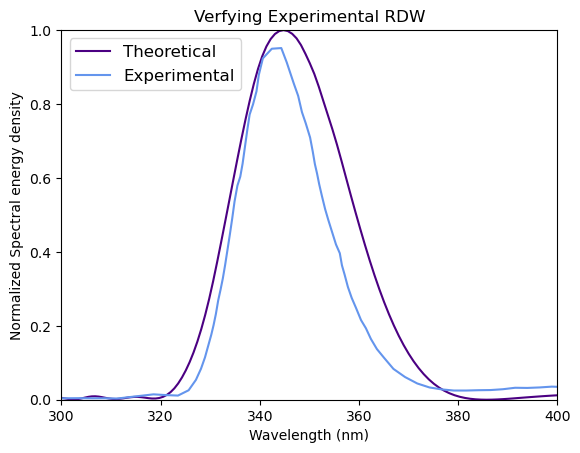

PyObject <matplotlib.legend.Legend object at 0x000002064A1CC5B0>

In [12]:
#overlay data on csv with simulated data for 3 modes

#get data from csv file
arr = np.loadtxt("\\Users\\kinca\\Documents\\ucf\\research\\lcls\\code\\61923\\overlay\\721\\363.csv", delimiter=",")
# plt.figure(figsize=(11,8))
j=1
#graph prameters
plt.xlim(300, 400)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Spectral energy density")
plt.ylim(0,1)
plt.title("Verfying Experimental RDW")
color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])
#plotting arrays/variables
λ= Array{Any}(undef,100) #arbituary lengths
Iλ= Array{Any}(undef,100)
Iλ_norm1=Array{Any}(undef,100)
    

λ, Iλ=Processing.getIω(compressor_stg3[a, j], :λ,1) #get values of from the compressor function
Iλ1=Iλ[:,1,1] #first mode
Iλ2=Iλ[:,2,1] #second mode
Iλ3=Iλ[:,3,1] #third mode
λ1=λ
λ2=λ
λ3=λ
 
c=1300 #variable to limit the range of plotted, for cleaniness/proper normalization in the window
b=1300
e=1500

arr_norm= (arr[:,2] / maximum(arr[:,2])) #normalize SED from imported csv

λ1=first(λ1,c) #filter out data points greater than window to normalize properly
# λ1=last(λ1,100) #filter out data points greater than window to normalize properly
Iλ1=first(Iλ1, c) #need the arrays to be the same size for plotting
#  Iλ1=last(Iλ1, 100) #need the arrays to be the same size for plotting
Iλ_norm1= (Iλ1 / maximum(Iλ1)) #normalize SED 
    
λ2=first(λ2,b) #filter out data points greater than window to normalize properly
#λ2=last(λ2,500) #filter out data points greater than window to normalize properly
Iλ2=first(Iλ2, b) #need the arrays to be the same size for plotting
# Iλ2=last(Iλ2, 500) #need the arrays to be the same size for plotting
Iλ_norm2= (Iλ2 / maximum(Iλ2)) #normalize SED 

λ3=first(λ3,e) #filter out data points greater than window to normalize properly
#λ3=last(λ3,e) #filter out data points greater than window to normalize properly
Iλ3=first(Iλ3, e) #need the arrays to be the same size for plotting
#Iλ3=last(Iλ3, e) #need the arrays to be the same size for plotting
Iλ_norm3= (Iλ3 / maximum(Iλ3)) #normalize SED 


#plot the data
plt.plot(λ1*1e9, Iλ_norm1, label="Theoretical", color="$(color[j])")
#plt.plot(λ2*1e9, Iλ_norm2, label="Mode HE12", color="$(color[j+1])")
#plt.plot(λ3*1e9, Iλ_norm3, label="Mode HE13", color="$(color[j+2])")
plt.plot( arr[:,1], arr_norm[:,1], label="Experimental", color=:cornflowerblue) #plot the imported data

plt.legend( loc="upper left", fontsize=12) #moves legend to best location




(1019,)
(1019, 4, 1)
(1019,)
(1019,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


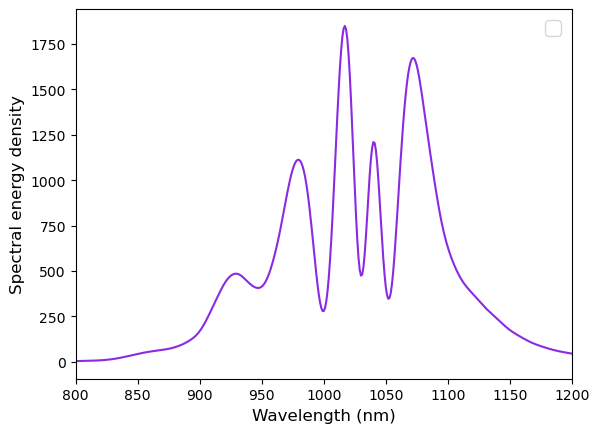

PyObject <matplotlib.legend.Legend object at 0x000001EAD8F5DC30>

In [112]:
#graph simulated data for wavelegnth domain

#graph parameters
plt.xlim(800,1200)
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Spectral energy density", fontsize=12)
#plt.ylim(0,45)
#plt.title("SED vs Wavelength for varying modes for $(gas3) at $(pressure3) bar $(energy3*1e6)uJ")
color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])


λ2, Iλ2=Processing.getIω(compressor_stg2[a], :λ,flength2, specrange=(100e-9,1200e-9), resolution=10e-9) #get values of from the compressor function
Iλ2=dropdims(sum(Iλ2[:,:,end], dims=2), dims=2) #sum the dimensions (modes) and drop so arrays are the same size


plt.plot(λ2*1e9, Iλ2, color="$(color[2])") #plot data
plt.legend( loc="best", fontsize=15) #moves legend to best location, increases size

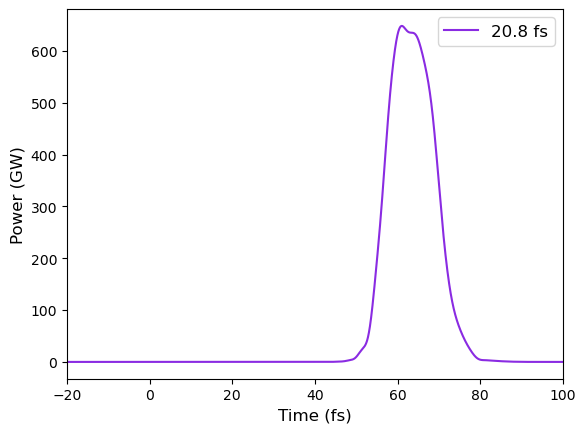

PyObject <matplotlib.legend.Legend object at 0x000001EA30AF13F0>

In [114]:
#graph simulated data for time domain  

#graph parameters
plt.xlim(-20,100)
plt.xlabel("Time (fs)", fontsize=12)
plt.ylabel("Power (GW)", fontsize=12)
#plt.ylim(0,6)
#plt.title("SED vs Wavelength for varying modes for $(gas3) at $(pressure3) bar $(energy3*1e6)uJ")
color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

t, Et=Processing.getEt(compressor_stg3[a,i], flength3,  bandpass=(150e-9,170e-9), FTL=false, propagate=nothing) #get values of from the compressor function in time domain
Et=abs2.(Et)#only nonnegative values of power
Et=dropdims(sum(Et, dims=2), dims=2) #sum the dimensions (modes) and drop so arrays are the same size

plt.plot(t*1e15, Et*1e-6,label="20.8 fs", color="$(color[2])") #plot data
plt.legend( loc="best", fontsize=12) #moves legend to outside the graph and populates with gas and pressure